# Script to prompt LLMs

In [9]:
# import packages
import requests
import json
import pandas as pd
import os
import openai
from openai import OpenAI
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm

from visualization import *
from utils import *

In [ ]:
# If OpenAI used
# Get API key from the environment variable
api_key = os.environ.get('OPENAI_API_KEY')

# Set the API key
openai.api_key = api_key

In [ ]:
# Define function to create a prompt
def create_prompt(object_name, N_responses):
    #prompt = f"Generate alternative uses for the object [{object_name}]."
    prompt = f"""
        You are meant to assist students in group ideation. They are asked to propose alternative
        uses for an object and you should propose yours to give them ideas as well as inspire them to 
        explore other uses. 
        You are a very creative, open-minded person and can propose creative, out-of-the-box ideas while staying realistic. 
        Your ideas will be even more appreciated if they are original or useful in real-life or both.
        
        Generate alternative uses for the object [{object_name}]. 
        
        Provide {N_responses} alternative uses, each explained in a concise sentence and following these examples: 
        Sock, Color it and maybe make a snake
        Sock, Use it as a puppet
        Sock, Use it as a dusting cloth
        """
        
    return prompt


# Define function to call the LLM API
def call_openai_api(prompt):
    client = OpenAI()
    response = client.chat.completions.create(
        model = "gpt-3.5-turbo-0125",
        #model="gpt-4-0125-preview", 
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": prompt}
            ]#,
        #seed=seed,
        #max_tokens=200,
        #temperature=temperature,
        )
    return response


# Define function to store the result in a JSON file
def store_result_json(object_name, alternative_uses):
    result = [{"object_name": object_name, "alternative_uses": use} for use in  alternative_uses.split("\n") if use.strip()]
    with open(f"./data_ocsai/input_ocsai/aut_{object_name}.json", "w") as json_file:
        json.dump(result, json_file)


# Define function to create a CSV file and Pandas DataFrame
def create_csv_and_dataframe(object_name):
    with open(f"./data_ocsai/input_ocsai/aut_{object_name}.json", "r") as json_file:
        data = json.load(json_file)
    df = pd.DataFrame(data)
    
    # remove prefix
    df['alternative_uses']= df['alternative_uses'].apply(lambda x: x.split(", ", 1)[1])
    #df['alternative_uses'] = df['alternative_uses'].str.split(f': ').str[1]
    #df['alternative_uses'] = df['alternative_uses'].str.split(f'{object_name}: ').str[1]
    
    #rename the columns to fit ocsai format
    df = df.rename(columns={"object_name": "prompt", "alternative_uses": "response"})
    
    # save for evaluation
    #df.to_csv(f"./data_ocsai/input_ocsai/aut_{object_name}.csv", index=False)
    
    # Delete the JSON file
    os.remove(f"./data_ocsai/input_ocsai/aut_{object_name}.json")
    
    return df

# Define function to estimate the price of an OpenAI API request
def estimate_price(prompt_tokens, response_tokens):
    # Define your pricing model (e.g., price per token)
    price_per_input_token = 0.50 / 1e6 # gpt3.5-turbo-0125
    price_per_output_token = 1.5 / 1e6 # gpt3.5-turbo-0125
    #price_per_input_token = 10 / 1e6 # gpt4-0125-preview
    #price_per_output_token = 30 / 1e6 # gpt4-0125-preview
    
    # Estimate the price based on the total number of tokens
    price = (prompt_tokens * price_per_input_token) + (response_tokens * price_per_output_token)
    return price

# plot mean from outputs LLMs in the histogram of ground truth
def plot_mean_histogram(ocsai_eval, ground_truth, object_name, ax):
    plt.figure(figsize=(10, 6))
    
    object_ground_truth = ground_truth[ground_truth['prompt'] == object_name]
    
    sns.histplot(object_ground_truth['target'], kde=True, label='Humans', ax = ax)
    ax.vlines(ocsai_eval['originality'].mean(), 0, ax.get_ylim()[1], colors='red', linestyles='dashed', label='LLM')
    ax.set_title(f'Creativity on AUT for {object_name}')
    ax.legend()
    #plt.xlabel('Mean')
    #plt.ylabel('Frequency')

### Main function

In [ ]:
ground_truth = pd.read_csv('./../data/cleaned_all_data.csv')

objects = list(ground_truth['prompt'].value_counts().head(4).index)
print(f"Top {len(objects)} of objects in the dataset: {objects}")

In [ ]:
def pipeline_object(object_name, N_responses):
    prompt = create_prompt(object_name, N_responses)
    response = call_openai_api(prompt)
    
    response_content = response.choices[0].message.content
    system_fingerprint = response.system_fingerprint
    prompt_tokens = response.usage.prompt_tokens
    completion_tokens = response.usage.total_tokens - response.usage.prompt_tokens

    print(f"System fingerprint: {system_fingerprint}")
    print(f"Prompt tokens: {prompt_tokens}")
    print(f"Completion tokens: {completion_tokens}")

    price = estimate_price(prompt_tokens, completion_tokens)
    print(f"Estimated price: ${price}")
    
    # store
    store_result_json(object_name, response_content)
    df = create_csv_and_dataframe(object_name)
    return df

def call_api_ocsai(prompt, output_llm):
    base_url = 'https://openscoring.du.edu/llm'
    model = 'ocsai-chatgpt'
    input_value = f"{prompt}, {output_llm}"
    input_type = 'csv'
    elab_method = 'whitespace'
    language = 'English'
    task = 'uses'
    question_in_input = 'false'
    
    # Encode special characters in the input value
    input_value_encoded = input_value.replace(' ', '%20').replace(',', '%2C')
    
    # Construct the URL
    url = f"{base_url}?model={model}&prompt={prompt}&input={input_value_encoded}&input_type={input_type}&elab_method={elab_method}&language={language}&task={task}&question_in_input={question_in_input}"
    
    response = requests.get(url)
    
    if response.status_code != 200:
        print(f"Error: {response.status_code}")
        return None
    
    return response.json()

## Call to GPT

In [ ]:
# Run the pipeline for each object
object = objects[0]

df = pipeline_object(object, 10)
print(f"length of df: {len(df)}")
df.head()

## Evaluation by ocsai

In [ ]:
for i in tqdm(range(len(df))):
    df.loc[i, 'originality_ocsai'] = call_api_ocsai(df.loc[i, 'prompt'], df.loc[i, 'response'])['scores'][0]['originality']  # see if we can speed up eval if we pass batches of sentences
    df.loc[i, 'elaboration_ocsai'] = call_api_ocsai(df.loc[i, 'prompt'], df.loc[i, 'response'])['scores'][0]['elaboration']

df.head()

In [ ]:
# check if there are any NaNs
if df.isnull().values.any():
    print("There are NaNs in the DataFrame")
else:
    df.to_csv(f'./data_ocsai/aut_{object}.csv', index=False) 
    print("Saved successfully")

In [ ]:
# Evaluate (after loading manually the csv on ocsai)
brick_ocsai_eval = pd.read_csv('./data_ocsai/aut_brick.csv')
box_ocsai_eval = pd.read_csv('./data_ocsai/aut_box.csv')
knife_ocsai_eval = pd.read_csv('./data_ocsai/aut_knife.csv')
rope_ocsai_eval = pd.read_csv('./data_ocsai/aut_rope.csv')

# merge the datasets for all objects
ocsai_eval_merged = pd.concat([brick_ocsai_eval, box_ocsai_eval, knife_ocsai_eval, rope_ocsai_eval])
print(f"Length of the merged dataset: {len(ocsai_eval_merged)}")
print(f"Object: {ocsai_eval_merged['prompt'].unique()}")
ocsai_eval_merged.head()

In [ ]:
# save dataset: change name
#ocsai_eval_merged.to_csv('./data_ocsai/merged_df/ocsai_eval_merged_30_gpt_4.csv', index=False) 

In [11]:
# load data
ocsai_eval_merged_gpt35_30 = pd.read_csv('./data_ocsai/merged_df/ocsai_eval_merged_30_gpt_3_5.csv')
ocsai_eval_merged_gpt4_30 = pd.read_csv('./data_ocsai/merged_df/ocsai_eval_merged_30_gpt_4.csv')

ocsai_eval_merged_gpt35_100, ocsai_eval_merged_gpt35_4x25 = load_data_exp1('gpt_35')
ocsai_eval_merged_gpt4_100, ocsai_eval_merged_gpt4_4x25 = load_data_exp1('gpt_4')

display(ocsai_eval_merged_gpt35_100.head(2), ocsai_eval_merged_gpt35_4x25.head(2), ocsai_eval_merged_gpt4_100.head(2), ocsai_eval_merged_gpt4_4x25.head(2))

,prompt,response,originality,elaboration
0,box,Use it as a makeshift stool for reaching high ...,1.7,10.0
1,box,Transform it into a mini-garden by adding soil...,3.0,10.0


,prompt,response,originality,elaboration
0,box,Use it as a mini herb garden by planting herbs...,3.0,11.0
1,box,Convert it into a unique wall shelf by adding ...,2.0,12.0


,prompt,response,originality,elaboration
0,box,Transform it into a mini garden for succulents.,3.0,8.0
1,box,Use it as a makeshift sled on snowy days.,2.0,9.0


,prompt,response,originality,elaboration
0,box,Transform it into a mini greenhouse for starti...,3.0,9.0
1,box,Cut out shapes and use it as a stencil for art...,3.0,12.0


### Evaluate similarity of responses

- rouge score: need to find pairs of sentences
- semantic distance
- use embeddings 

In [ ]:
# compute the rouge score between the outputs of the LLMs

def evaluate_rouge(sentences):
    
    #create pairs of sentences
    pairs = 
    

    rouge = evaluate.load('rouge')
    
    rouge_scores = rouge.compute(predictions=predictions, references=references)

    return rouge_scores


In [ ]:
hofelich_elaboration = pd.read_csv("./../data/hofelich/HMSL_Elaboration_scores_all.csv")

hofelich_elaboration.head()

## Evaluate elaboration

In [19]:
import nltk
from nltk.corpus import stopwords

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

# Define stop words
stop_words = set(stopwords.words('english'))

# Function to calculate elaboration
def calculate_elaboration(sentence, remove_stop_words):
    # Tokenize the sentence
    tokens = nltk.word_tokenize(sentence)
    
    if remove_stop_words == True:
        # Remove stop words
        tokens = [word for word in tokens if word.lower() not in stop_words]
    
    # Count the remaining words
    return len(tokens)

[nltk_data] Error loading punkt: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


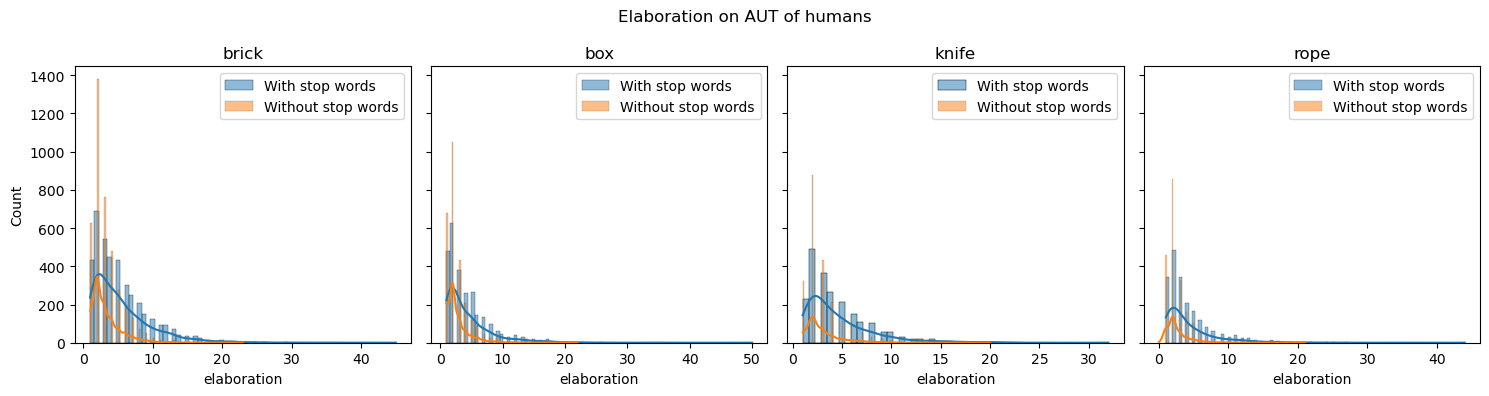

In [35]:
# elaboration humans
# apply normal and custom elaboration to ground truth
ground_truth_elab = ground_truth.copy()
ground_truth_elab['elaboration'] = ground_truth_elab['response'].apply(calculate_elaboration, remove_stop_words = False)
ground_truth_elab['elaboration_2'] = ground_truth_elab['response'].apply(calculate_elaboration, remove_stop_words = True)

# print average number of elaboration per object:


fig, axs = plt.subplots(1,4, figsize=(15, 4), sharey=True)
for i, object_name in enumerate(objects):
    object_ground_truth_elab = ground_truth_elab[ground_truth_elab['prompt'] == object_name]
    
    sns.histplot(object_ground_truth_elab['elaboration'], label=f'With stop words', ax = axs[i], kde = True)
    sns.histplot(object_ground_truth_elab['elaboration_2'], label=f'Without stop words', ax = axs[i], kde = True)
    
    axs[i].set_title(f'{object_name}')
    axs[i].legend()
plt.suptitle(f'Elaboration on AUT of humans')
plt.tight_layout()
plt.show()

In [36]:
test = ocsai_eval_merged_gpt35_100.copy()

# Apply the calculate_elaboration function to the "response" column
test['elaboration_2'] = test['response'].apply(calculate_elaboration, remove_stop_words = True)

test.head()

,prompt,response,originality,elaboration,elaboration_2
0,box,Use it as a makeshift stool for reaching high ...,1.7,10.0,7
1,box,Transform it into a mini-garden by adding soil...,3.0,10.0,6
2,box,Cut it up to create a DIY puzzle for kids.,2.7,10.0,6
3,box,Use it as a base for a homemade pinhole camera.,3.0,10.0,6
4,box,Turn it into a birdhouse by adding a small ent...,2.0,13.0,8


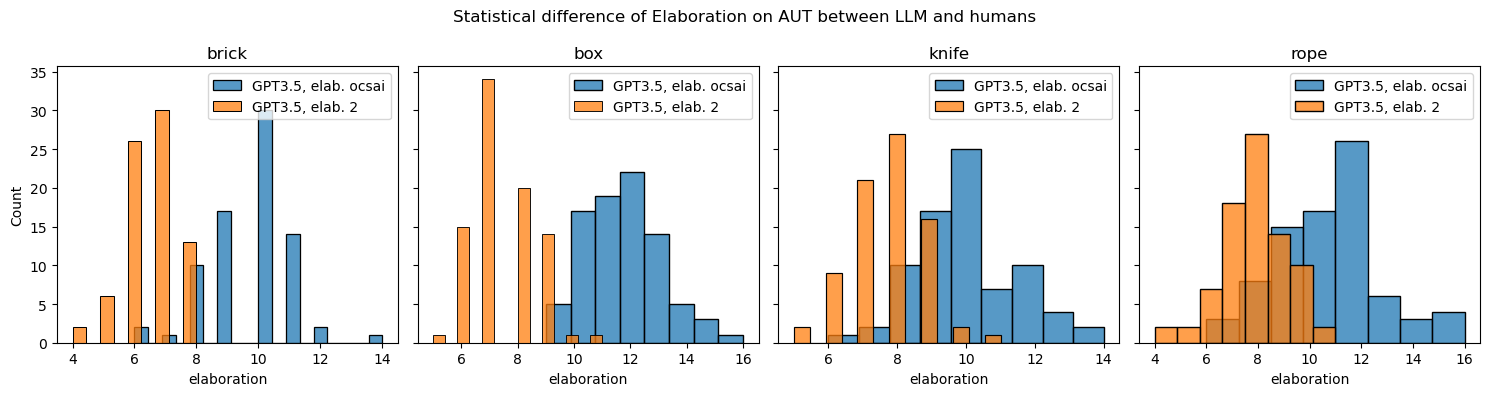

In [37]:
fig, axs = plt.subplots(1,4, figsize=(15, 4), sharey=True)
for i, object_name in enumerate(objects):
    # normalize the values in ground truth and ocsai_eval_merged
    object_test = test[test['prompt'] == object_name]

    sns.histplot(object_test['elaboration'], label=f'GPT3.5, elab. ocsai', ax = axs[i])
    sns.histplot(object_test['elaboration_2'], label=f'GPT3.5, elab. 2', ax = axs[i])
    
    axs[i].set_title(f'{object_name}')
    axs[i].legend()
plt.suptitle(f'Statistical difference of Elaboration on AUT between LLM and humans')
plt.tight_layout()
plt.show()